In [1]:
import os
import re

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from ndspflow.workflows import BIDS, WorkFlow
from timescales.fit import PSD

from mne.io import read_raw_edf
from mne_bids import BIDSPath, read_raw_bids

import nilearn
from nilearn import plotting, image 

from sklearn.preprocessing import minmax_scale

from timescales.fit import PSD
from neurodsp.spectral import compute_spectrum
from neurodsp.utils.norm import normalize_sig

## MNI Opeen iEEG Atlas Data

In [2]:
# Load region and channel info
rpath = '/Users/ryanhammonds/projects/data/sleep2/Information/RegionInformation.csv'
regions = pd.read_csv(rpath)

cpath = '/Users/ryanhammonds/projects/data/sleep2/Information/ChannelInformation.csv'
ch_info = pd.read_csv(cpath)

# Remove single quotes from channel names
ch_info['Channel name'] = [i[1:-1] for i in ch_info['Channel name']]

# Get row inds and channel names
rinds = [(i, j) for i, j in ch_info['Region'].items()]
inds = [i[0] for i in rinds]
rinds = [i[1] for i in rinds]

select = [i[1:-1] for i in ch_info.iloc[inds]['Channel name']]
select.sort()

# List of file names
files = os.listdir('/Users/ryanhammonds/projects/data/sleep2/data2')
files_noext  = [i[:-5] for i in files]

# Sort
inds = np.argsort(files_noext)
files_noext = np.array(files_noext)[inds]
files = np.array(files)[inds]

# Filter for Dixi intracerebral electrodes (largest sample size)
files_filt = []
regions_inds = []

for i, f in enumerate(files_noext):
    
    if f[1] == 'D':
        ind = (ch_info['Channel name'] == f).values
        regions_inds.append(ch_info[ind]['Region'].values[0])
        files_filt.append(files[i])
        
regions_inds = np.array(regions_inds)

In [3]:
# Convert list of file strings to one concat string
file_str = ''
for f in files:
    file_str += f
    
ch_files = {
    'wake':{'files':[], 'coords':[]},
    'nrem2':{'files':[], 'coords':[]},
    'nrem3':{'files':[], 'coords':[]},
    'rem':{'files':[], 'coords':[]}
}

trial_lookup = {'W': 'wake', 'N': 'nrem2', 'D': 'nrem3', 'R': 'rem'}

regions = []

inds = []

for i, ch in enumerate(ch_info['Channel name'].values):
    m = re.search(ch + '.\.edf', file_str)
    
    if m is not None:
        
        
        fstr = m.group()
        trial = fstr[-5]
        
        if trial == 'R':
            # skip rem sleep
            continue
            
        key = trial_lookup[trial]
            
        ch_files[key]['files'].append(fstr)

        ch_files[key]['coords'].append(
            (ch_info.iloc[i].x, ch_info.iloc[i].y, ch_info.iloc[i].z)
        )
        
        regions.append(ch_info.iloc[i].Region)
        
        inds.append(i)

## Fit Timescales

In [4]:
base_path = '/Users/ryanhammonds/projects/data/sleep2/data2/'

fs = 200

wake_files = ch_files['wake']['files']
nrem_files = [*ch_files['nrem2']['files'], *ch_files['nrem3']['files']]

n_wake_files = len(wake_files)
n_nrem_files = len(nrem_files)

wake_taus = np.zeros(n_wake_files)
wake_rsq = np.zeros(n_wake_files)

nrem_taus = np.zeros(n_nrem_files)
nrem_rsq = np.zeros(n_nrem_files)

for i, f in tqdm(enumerate(wake_files), total=len(wake_files)):
    
    edf = read_raw_edf(base_path + f, verbose=False)
    
    sig = edf.get_data()[0]
    sig = normalize_sig(sig, 0, 1)
    
    psd = PSD()
    psd.compute_spectrum(sig, fs, ar_order=5, f_range=(.01, 20))
    psd.fit()
    
    wake_taus[i] = psd.tau
    wake_rsq[i] = psd.rsq
    
    
for i, f in tqdm(enumerate(nrem_files), total=len(nrem_files)):
    
    edf = read_raw_edf(base_path + f, verbose=False)
    
    sig = edf.get_data()[0]
    sig = normalize_sig(sig, 0, 1)
    
    psd = PSD()
    psd.compute_spectrum(sig, fs, ar_order=5, f_range=(.01, 20))
    psd.fit()
    
    nrem_taus[i] = psd.tau
    nrem_rsq[i] = psd.rsq

  0%|          | 0/520 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

In [5]:
# Organize results
inds = np.where(wake_rsq > .5)[0]
wake_taus = wake_taus[inds]
wake_rsq = wake_rsq[inds]
wake_coords = np.array(ch_files['wake']['coords'])[inds]
wake_taus_ms = wake_taus * 1000

inds = np.where(nrem_rsq > .5)[0]
nrem_taus = nrem_taus[inds]
nrem_rsq = nrem_rsq[inds]
nrem_coords = np.array([*ch_files['nrem2']['coords'], *ch_files['nrem3']['coords']])[inds]
nrem_taus_ms = nrem_taus * 1000

## Convert Timescales to Surface Map

In [6]:
# Load MNI template
template_path = '/Users/ryanhammonds/projects/data/sleep2/'
template_path += 'mni_icbm152_nlin_sym_09a_nifti/mni_icbm152_nlin_sym_09a/'
template_path += 'mni_icbm152_t1_tal_nlin_sym_09a.nii'
template = image.load_img(template_path)

# Wake timescales
wake_statmap = np.zeros_like(np.asanyarray(template.dataobj))
for c, t in zip(wake_coords, wake_taus_ms):
    i, j, k = image.coord_transform(*c, np.linalg.inv(template.affine))
    wake_statmap[int(i), int(j), int(k)] = t
wake_max_stat = wake_statmap.max()

# NREM timescales
nrem_statmap = np.zeros_like(np.asanyarray(template.dataobj))

for c, t in zip(nrem_coords, nrem_taus_ms):
    i, j, k = image.coord_transform(*c, np.linalg.inv(template.affine))
    nrem_statmap[int(i), int(j), int(k)] = t
nrem_max_stat = nrem_statmap.max()

# Smooth
radius = 20

wake_statmap = nilearn.image.new_img_like(template, wake_statmap)
wake_statmap_smooth = image.smooth_img(wake_statmap, radius)

nrem_statmap = nilearn.image.new_img_like(template, nrem_statmap)
nrem_statmap_smooth = image.smooth_img(nrem_statmap, radius)

In [7]:
# Wake: volumetric to surface
fsaverage = nilearn.datasets.fetch_surf_fsaverage(mesh='fsaverage')

curv_right = nilearn.surface.load_surf_data(fsaverage.curv_right)
curv_right_sign = np.sign(curv_right)
texture_right = nilearn.surface.vol_to_surf(wake_statmap_smooth, fsaverage.pial_right, radius=radius)

curv_left = nilearn.surface.load_surf_data(fsaverage.curv_left)
curv_left_sign = np.sign(curv_left)
texture_left = nilearn.surface.vol_to_surf(wake_statmap_smooth, fsaverage.pial_left, radius=radius)

# Scaling Note:
#   Min-max rescaling ensures full colorbar is used (not only positive values), this is a quirk of 
#   using nilearn/mpl to plot. NREM max is larger, so we use the min a it's negative to that both
#   wake and nrem start at the same value. Then we normalize the colorbar back to (0, max_tau).
wake_texture_right = minmax_scale(texture_right, (-nrem_max_stat, wake_max_stat))
wake_texture_left = minmax_scale(texture_right, (-nrem_max_stat, wake_max_stat))

# NREM: volumetric to surface
curv_right = nilearn.surface.load_surf_data(fsaverage.curv_right)
curv_right_sign = np.sign(curv_right)
texture_right = nilearn.surface.vol_to_surf(nrem_statmap_smooth, fsaverage.pial_right, radius=radius)

curv_left = nilearn.surface.load_surf_data(fsaverage.curv_left)
curv_left_sign = np.sign(curv_left)
texture_left = nilearn.surface.vol_to_surf(nrem_statmap_smooth, fsaverage.pial_left, radius=radius)

nrem_texture_right = minmax_scale(texture_right, (-nrem_max_stat, nrem_max_stat))
nrem_texture_left = minmax_scale(texture_right, (-nrem_max_stat, nrem_max_stat))

## Plot Surfaces

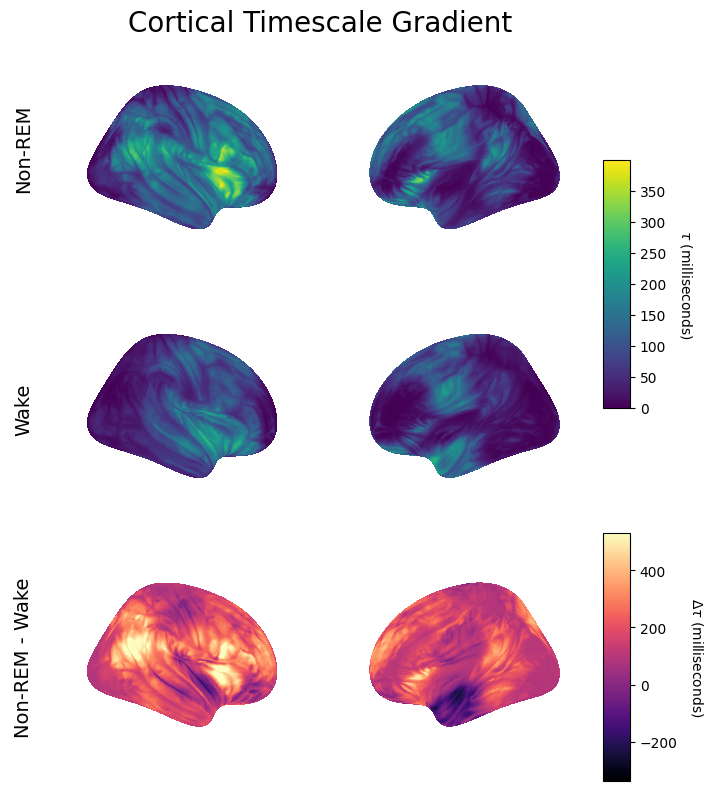

In [8]:
# Create grid
fig = plt.figure(figsize=(8, 10))
gs = plt.GridSpec(155, 110, figure=fig)
 
# Titles
tax = fig.add_subplot(gs[:5, :])
tax.text(.5, .5, 'Cortical Timescale Gradient', ha='center', va='center', size=20)
tax.axis('off')

tax0 = fig.add_subplot(gs[:55, :5])
tax0.text(.5, .5, 'Non-REM', rotation=90, ha='center', va='center', size=14)
tax0.axis('off')

tax1 = fig.add_subplot(gs[55:105, :5])
tax1.text(.5, .5, 'Wake', rotation=90, ha='center', va='center', size=14)
tax1.axis('off')

tax2 = fig.add_subplot(gs[105:155, :5])
tax2.text(.5, .5, 'Non-REM - Wake', rotation=90, ha='center', va='center', size=14)
tax2.axis('off')

# Subplots
ax0 = fig.add_subplot(gs[5:55, 5:55], projection='3d')
ax1 = fig.add_subplot(gs[5:55, 55:105], projection='3d')

ax2 = fig.add_subplot(gs[55:105, 5:55], projection='3d')
ax3 = fig.add_subplot(gs[55:105, 55:105], projection='3d')

cax0 = fig.add_subplot(gs[30:80, 105:])

ax4 = fig.add_subplot(gs[105:155, 5:55], projection='3d')
ax5 = fig.add_subplot(gs[105:155, 55:105], projection='3d')

cax1 = fig.add_subplot(gs[105:, 105:])


# Plot
view = 'lateral'

# NREM
plotting.plot_surf_stat_map(
    fsaverage.infl_right, nrem_texture_right, hemi='right',
    title='', colorbar=False, view=view, vmax=nrem_max_stat,
    symmetric_cbar=False, threshold=None, cmap='viridis',
    axes=ax0, thresh=.01
)

plotting.plot_surf_stat_map(
    fsaverage.infl_left, nrem_texture_left, hemi='left',
    title='', colorbar=False, view=view, vmax=nrem_max_stat,
    symmetric_cbar=False, threshold=None, cmap='viridis',
    axes=ax1, thresh=.01
)

# Wake
plotting.plot_surf_stat_map(
    fsaverage.infl_right, wake_texture_right, hemi='right',
    title='', colorbar=False, view=view, vmax=nrem_max_stat,
    symmetric_cbar=False, threshold=None, cmap='viridis',
    axes=ax2, thresh=.01
)

plotting.plot_surf_stat_map(
    fsaverage.infl_left, wake_texture_left, hemi='left',
    title='', colorbar=False, view=view, vmax=nrem_max_stat,
    symmetric_cbar=False, threshold=None, cmap='viridis',
    axes=ax3, thresh=.01
)

# NREM - Wake
nrem_minus_wake_left = nrem_texture_left-wake_texture_left
nrem_minus_wake_right = nrem_texture_right-wake_texture_right

plotting.plot_surf_stat_map(
    fsaverage.infl_right, nrem_minus_wake_right, hemi='right',
    title='', colorbar=False, view=view, vmax=nrem_max_stat,
    symmetric_cbar=False, threshold=None, cmap='magma',
    axes=ax4
)

plotting.plot_surf_stat_map(
    fsaverage.infl_left, nrem_minus_wake_left, hemi='left',
    title='', colorbar=False, view=view, vmax=nrem_max_stat,
    symmetric_cbar=False, threshold=None, cmap='magma',
    axes=ax5
)

# Colorbars
norm = matplotlib.colors.Normalize(vmin=0, vmax=nrem_max_stat)
fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap='viridis'),
             cax=cax0, orientation='vertical')

vmin = min(nrem_minus_wake_left.min(), nrem_minus_wake_right.min())
vmax = min(nrem_minus_wake_left.max(), nrem_minus_wake_right.max())

norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap='magma'),
             cax=cax1, orientation='vertical')

cax0.set_ylabel(r'$\tau$ (milliseconds)', rotation=-90, labelpad=20)
cax1.set_ylabel(r'$\Delta\tau$ (milliseconds)', rotation=-90, labelpad=20)

plt.savefig('cortical_timescales.pdf');

### Compare Human vs Rat Timescales

In [10]:
rat_wake_taus_ms = np.load('./rat_taus_lfp_wake.npy')
rat_nrem_taus_ms = np.load('./rat_taus_lfp_nrem.npy')

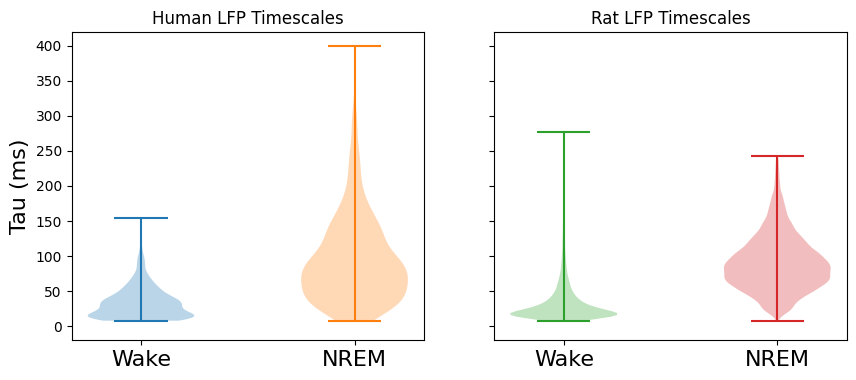

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True)

axes[0].violinplot(wake_taus_ms, positions=[0])
axes[0].violinplot(nrem_taus_ms, positions=[1])
axes[0].set_xticks([0, 1], ['Wake', 'NREM'], size=16)
axes[0].set_title('Human LFP Timescales')
axes[0].set_ylabel('Tau (ms)', size=16)

axes[1].violinplot([0], positions=[-100])
axes[1].violinplot([0], positions=[-101])

axes[1].violinplot(rat_wake_taus_ms, positions=[0], )
axes[1].violinplot(rat_nrem_taus_ms, positions=[1])
axes[1].set_xticks([0, 1], ['Wake', 'NREM'], size=16)
axes[1].set_title('Rat LFP Timescales')
axes[1].set_xlim(axes[0].get_xlim())
plt.savefig('human_v_rat_v1.pdf');

/var/folders/xq/64b6njb134n_vwp47x74rp240000gn/T/ipykernel_65655/4107444783.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in np.arange(0, 500, 50)], size=12)


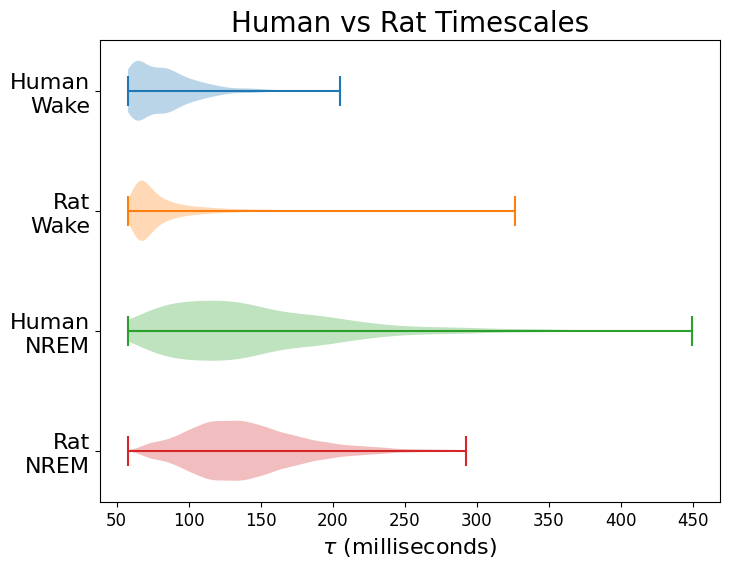

In [12]:
fig, ax = plt.subplots(figsize=(8, 6), sharey=True)

ax.violinplot(wake_taus_ms, positions=[3], vert=False)
ax.violinplot(rat_wake_taus_ms, positions=[2], vert=False)

ax.violinplot(nrem_taus_ms, positions=[1], vert=False)
ax.violinplot(rat_nrem_taus_ms, positions=[0], vert=False)

ax.set_yticks([0, 1, 2, 3][::-1], ['Human\nWake', 'Rat\nWake', 'Human\nNREM',  'Rat\nNREM'], size=16)
ax.set_xticklabels([str(i) for i in np.arange(0, 500, 50)], size=12)
ax.set_title('Human vs Rat Timescales', size=20)
ax.set_xlabel(r'$\tau$ (milliseconds)', size=16)
plt.savefig('human_v_rat_v2.pdf');